This tutorial showcases how to obtain wavescapes from real audio data. As it is the second notebook in a series of four, we recommand you to follow the previous one "1. Single Wavescape" before dwelving into this one, as functions and parameters presented previously are used here without much explanations.

The goal of this tutorial is only to show how to use the library; for explanations of the visualization's methodology and how to interpret wavescapes, please refer to [the official publication from Musicae Scientiae (dead link as it is not yet published)](dead)

Before beginning, be sure the module "wavescapes" and all its dependencies are properly installed on your machine or virtual environnement ( `pip install wavescapes`). ( _Note for DCML users tests: step not required as long as you are running this notebook on a local clone of the repo_ ). Run the cell below to check if the module was properly installed. 

In [1]:
'''
The shell line below will be removed once the last version of the library 
is publicly available through pip. Its purpose for now is just to redirect
the source code of the repo in the same place as this notebook.
'''
!ln -s ../wavescapes wavescapes

from wavescapes import single_wavescape

ln: wavescapes/wavescapes: File exists


Table of Content

1. Audio processing backend & Formats supported
2. Base case and ticks for seconds
2. CLP vs. Deep Chroma
4. Boosting

Throughout this tutorial, two audio files are used to demonstrate wavescapes on audio. They are also accompanied by two correspnding XML transcriptions acting as reference points to compare the performance of the audio processing. The two pieces chosen for the needs of this tutorial are the following:

1. [A string quartet recording](https://imslp.org/wiki/Special:ReverseLookup/84547) by the "Steve's Bedroom Band" of the first of the two Arabesques by Claude Debussy (L. 66) made publicly available under the Creative Common Attribution 3.0 License. Its [XML counterpart can be found here](https://musescore.com/classicman/scores/55396), but has been transposed to the key of F Major so that it is in the same key as the recording.
2. [An orchestral recording](https://imslp.org/wiki/Special:ReverseLookup/246990) by the "Czech National Symphony Orchestra" of the fourth movement of the Peer Gynt Suite No. 1 Op.46 by Edvard Grieg (which is more commonly known in the pop culture under the name "In the Hall of the Mountain King") made publicly available under the Creative Common Attribution 3.0 License. Its [XML counterpart can be found here](https://musescore.com/user/1580161/scores/4836471).

In [2]:
import os

def test_file_existence(filepath):
    if not os.path.isfile(filepath):
        raise Exception("'%s' does not exist."%filepath)

arabesque_audio = 'inputs/IMSLP84547-PMLP02383-T02_debussy_arabesque.mp3'
arabesque_xml = 'inputs/Arabesque_L._66_No._1_in_F_Major.musicxml'
mk_audio = 'inputs/IMSLP246990-PMLP02533-Peer_Gynt_Suite_No._1,_Op._46_-_IV._In_the_Hall_Of_The_Mountain_King.mp3'
mk_xml = 'inputs/In_the_Hall_of_the_Mountain_King.mxl'

for f in [arabesque_audio, arabesque_xml, mk_audio, mk_xml]:
    test_file_existence(f)

## 1. Audio processing backend & Formats supported

When it comes to producing wavescapes, the main difference between audio and symbolic data is the way pitch class content is retrieved from the input. This process is trivial for symbolic data, but quite complex for audio, and as such, it deserves to be tackled separately in its own notebook. 

The wavescapes library uses the [madmom](https://github.com/CPJKU/madmom) python library as its audio backend. Madmom is only used to retrieve pitch-class vector (or chromagrams) from the audio signal. By default, `madmom` nativealy support audio file in WAV format, but almost all existing audio file format can be supported through `madmom` if [ffmpeg](https://ffmpeg.org/). As the two audio files used in this tutorial are in `mp3`

## 2. Base case and ticks for seconds

The pitch-class vectors produced from the library are then used to build the wavescape without any consideration of their source, whether its from symbolic or audio data. As such, with the exception of `removing_unpitched_tracks`, all parameters introduced in the previous notebook works the same way on audio input.

Performing wavescape on audio is pretty simple, just provide the path of an audio file to the `single_wavescape` function, the celle below generate the wavescapes on the 5th coefficient on the quartet recording of Debussy's Arabesque:

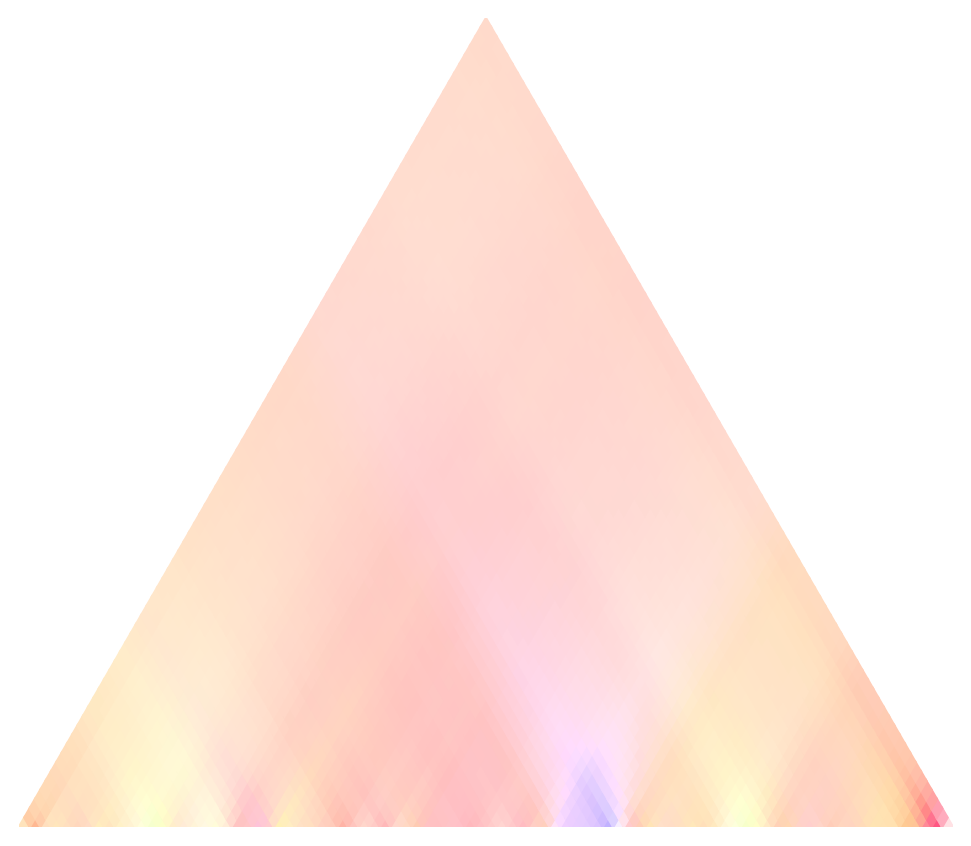

In [3]:
single_wavescape(arabesque_audio, 500, coefficient=5,  aw_size=3)

The argument `aw_size` still holds the function of specifying the length of the shortest segment of the wavescape, but its unit is in second instead of quarter notes. In the cell above, an analysis window size of 2.5 seconds was chosen to speed up the generation of the plot. The parameters `tick_ratio` and `tick_factor` and can be used to draw ticks that represent the seconds of the recording (without setting any value to `tick_offset` so that the tick numbers start at 0):

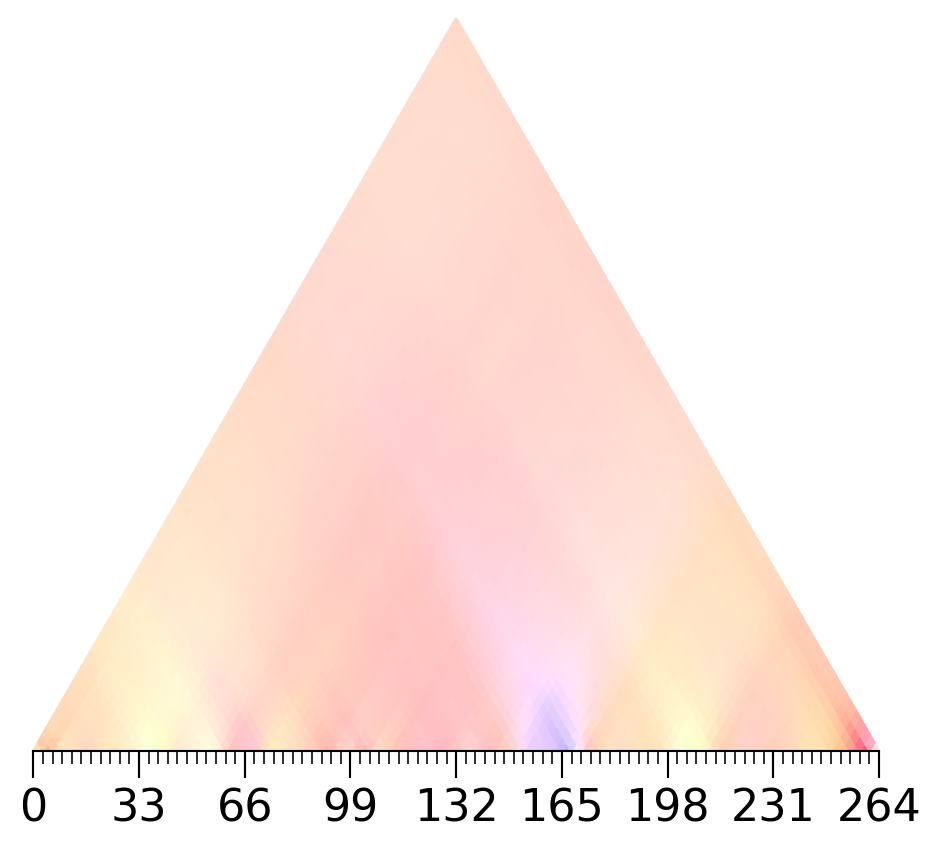

In [4]:
single_wavescape(arabesque_audio, 500, coefficient=5,  aw_size=3,\
                 tick_ratio=1, tick_factor=3)

Although the plot produced is readable, the colors are quite faded away. Without knowledge of the tonality of the piece, it is hard to know whether the color are faded because the tonality of the piece does not resonate well with Fourier's 5th coefficient, or because the audio processing had trouble extracting the relevant pitch content. 

Fortunately, we can use the XML transcript as a way to check the accuracy of the audio processing, below is a function that display wavescape from symbolic and audio data next to each other for comparison purpose:

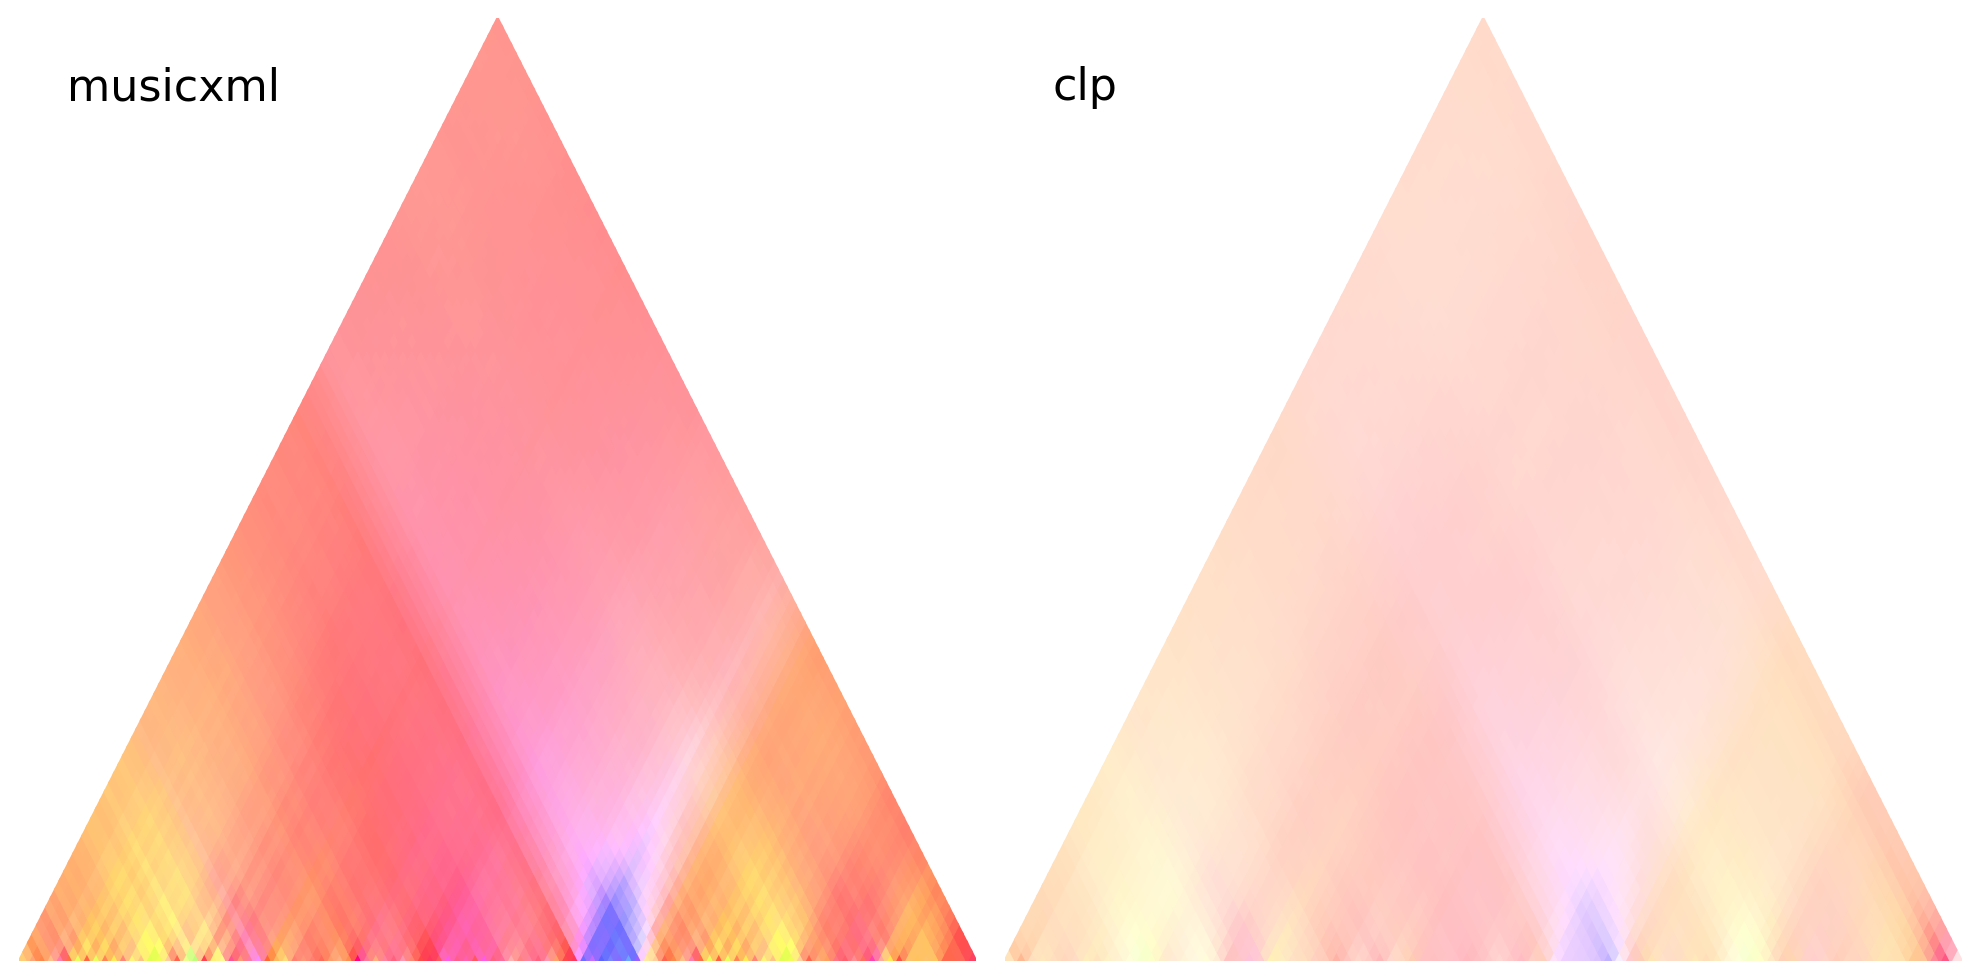

In [5]:
import matplotlib.pyplot as plt
#aw size choseon so both files are cuts in roughly 105 segments
arabesque_xml_aw = 4 #106.1 bars * 4 == 425 quarter notes in length
arabesque_mp3_aw = 3 #4:21 == 261s

def symbolic_vs_audio(sym_fp, audio_fp, sym_aw, audio_aw, indiv_width, coefficient, deep_chroma=False, boosting=False):
    dpi = 96
    total_width = (2*indiv_width)/dpi
    sym_label = sym_fp.split('.')[-1]
    audio_label = ('dc' if deep_chroma else 'clp') + ('_boost' if boosting else '')
    fig = plt.figure(figsize=(total_width, indiv_width/dpi), dpi=dpi)
    
    
    ax1 = fig.add_subplot(1,2,1)
    single_wavescape(sym_fp, indiv_width, coefficient=coefficient, aw_size=sym_aw, ax=ax1, label=sym_label)
    
    magn_stra = 'boost'if boosting else '0c'
    ax2 = fig.add_subplot(1,2,2)
    single_wavescape(audio_fp, indiv_width, coefficient=coefficient, aw_size=audio_aw, ax=ax2, label=audio_label, deep_chroma=deep_chroma, magn_stra=magn_stra)

symbolic_vs_audio(arabesque_xml, arabesque_audio, arabesque_xml_aw, arabesque_mp3_aw, 500, 5)

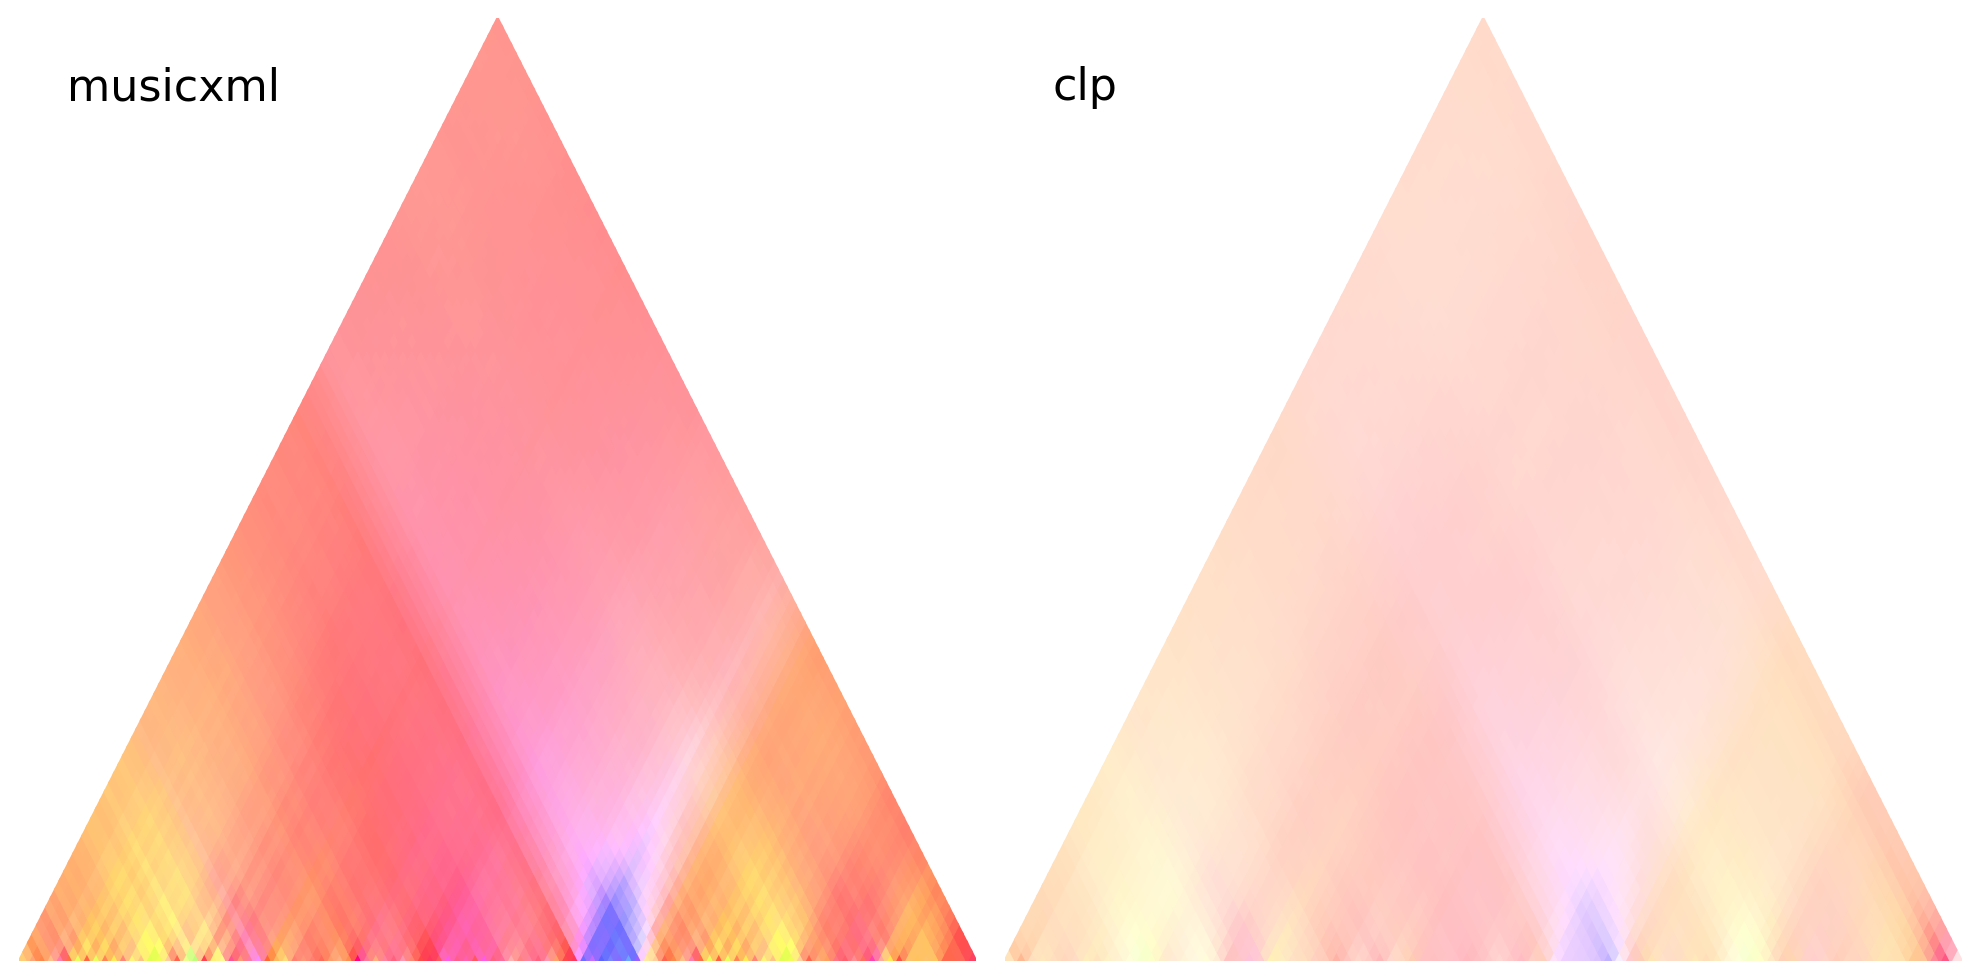

In [6]:
symbolic_vs_audio(arabesque_xml, arabesque_audio, arabesque_xml_aw, arabesque_mp3_aw, 500, 5)

## 3. CLP vs Deep Chroma

Two methods of retrieval of chromagram proposed by madmom are implemented in the wavescapes library:

1. The **Compression Log Pitch (CLP)** Chroma Processor
2. The **Deep Chroma** Processor

By default, the CLP Chroma Processor is used, to enable the Deep Chroma processor, set the parameter `deep_chroma` from `single_wavescape` to the value `True`

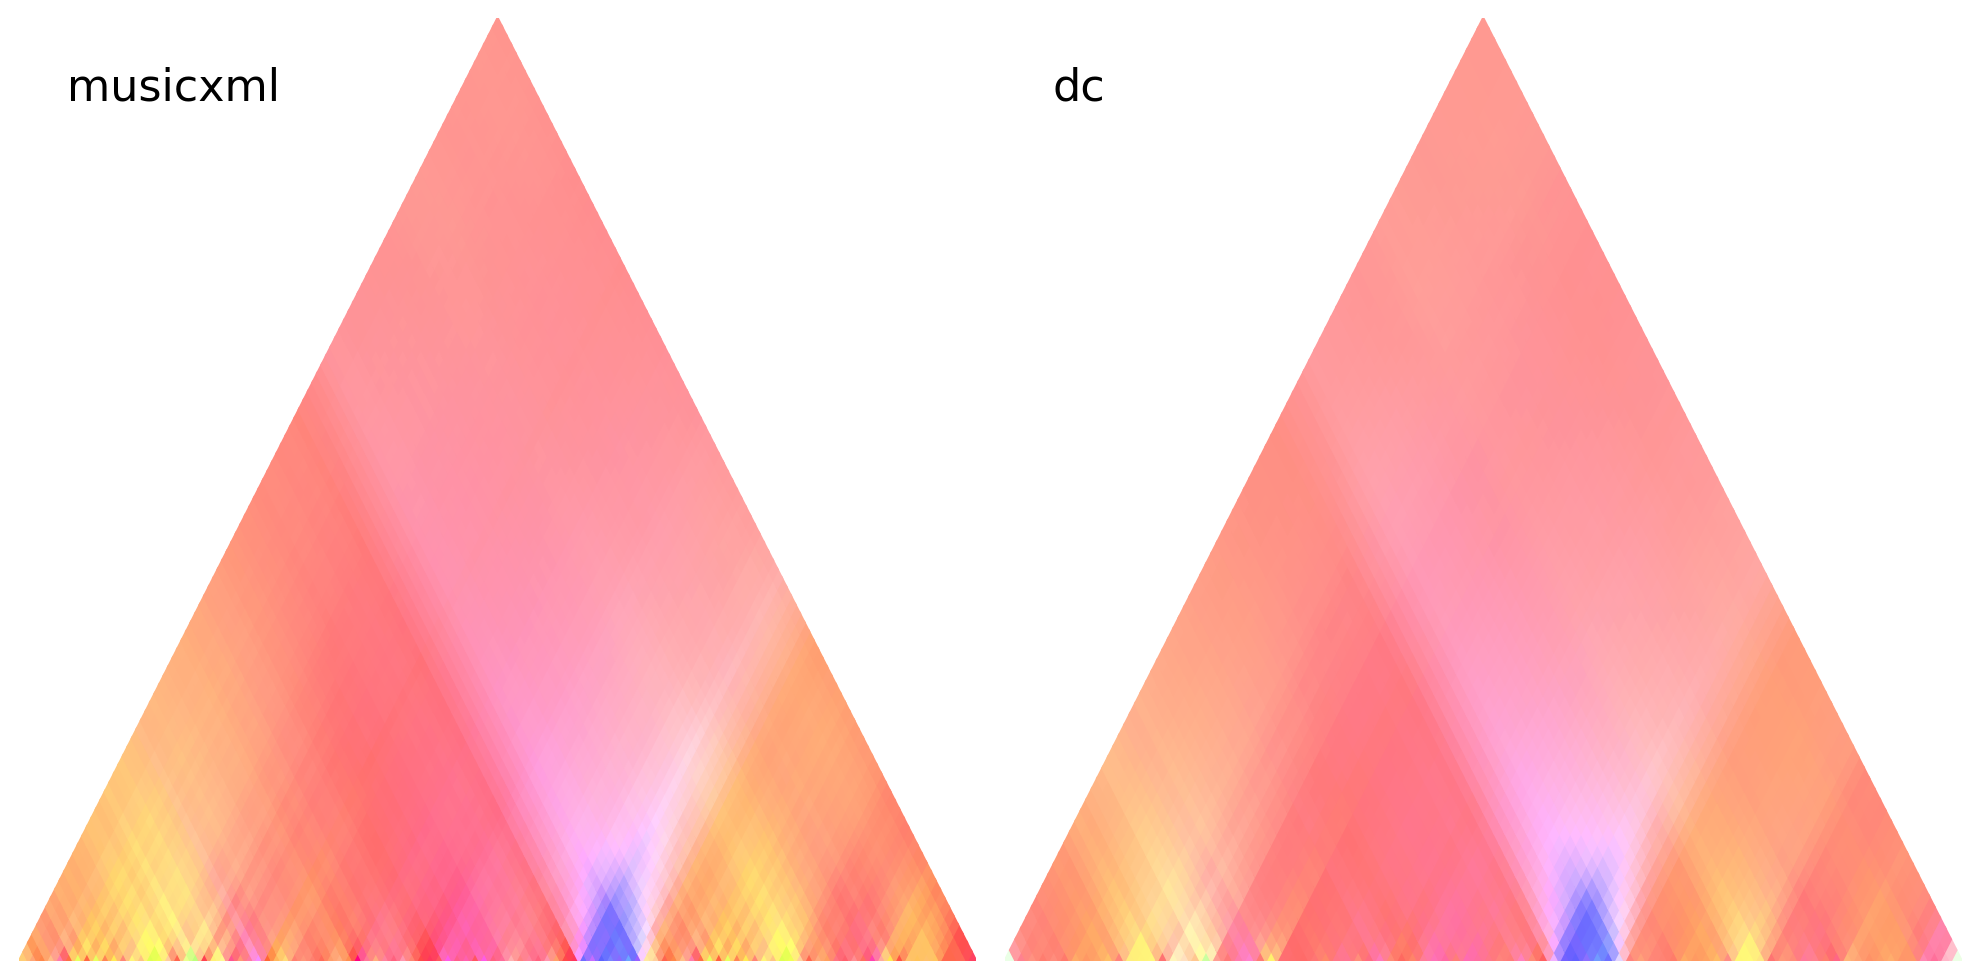

In [7]:
symbolic_vs_audio(arabesque_xml, arabesque_audio, arabesque_xml_aw, arabesque_mp3_aw, 500, 5, deep_chroma=True)

/Users/cedricviaccoz/wavescapes/tutorials/wavescapes/color.py:200: UserWarning: Max magnitude of 0.628007 observed for coeff. number 5, boosting all magnitudes by 159.23% of their original values
  warn(msg)


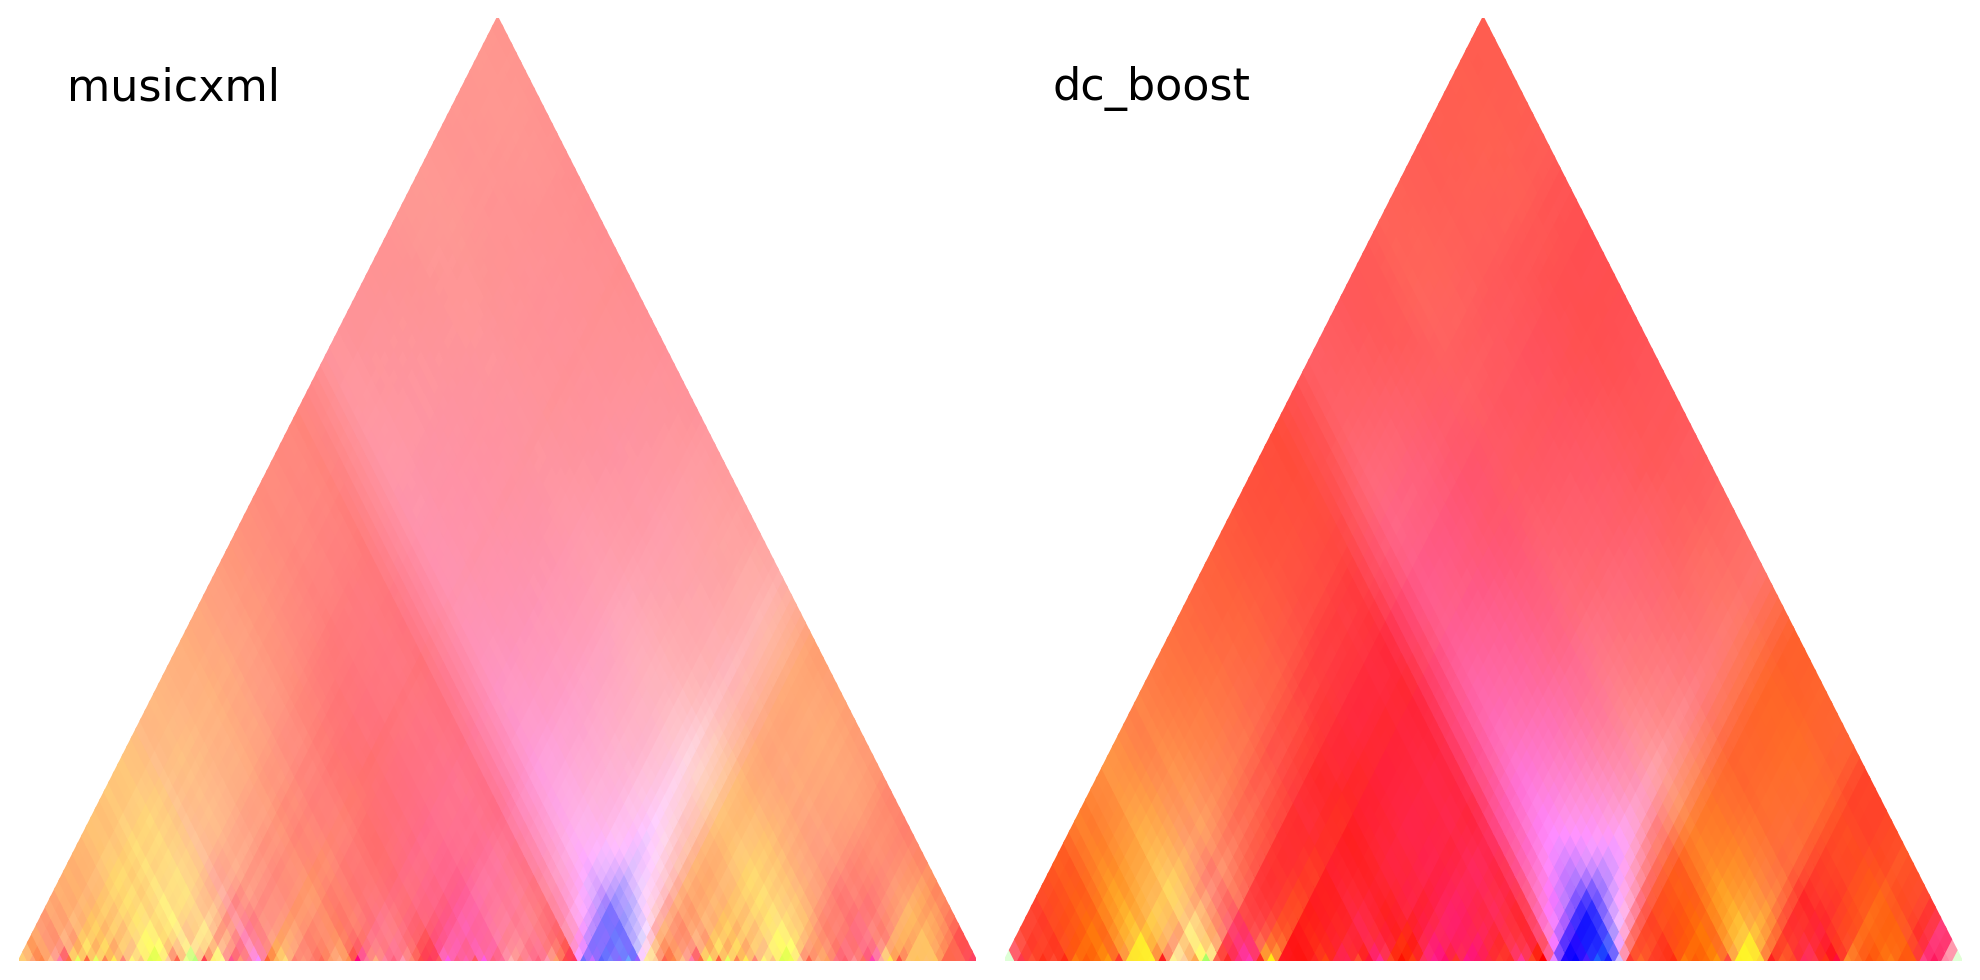

In [8]:
symbolic_vs_audio(arabesque_xml, arabesque_audio, arabesque_xml_aw, arabesque_mp3_aw, 500, 5, deep_chroma=True, boosting=True)

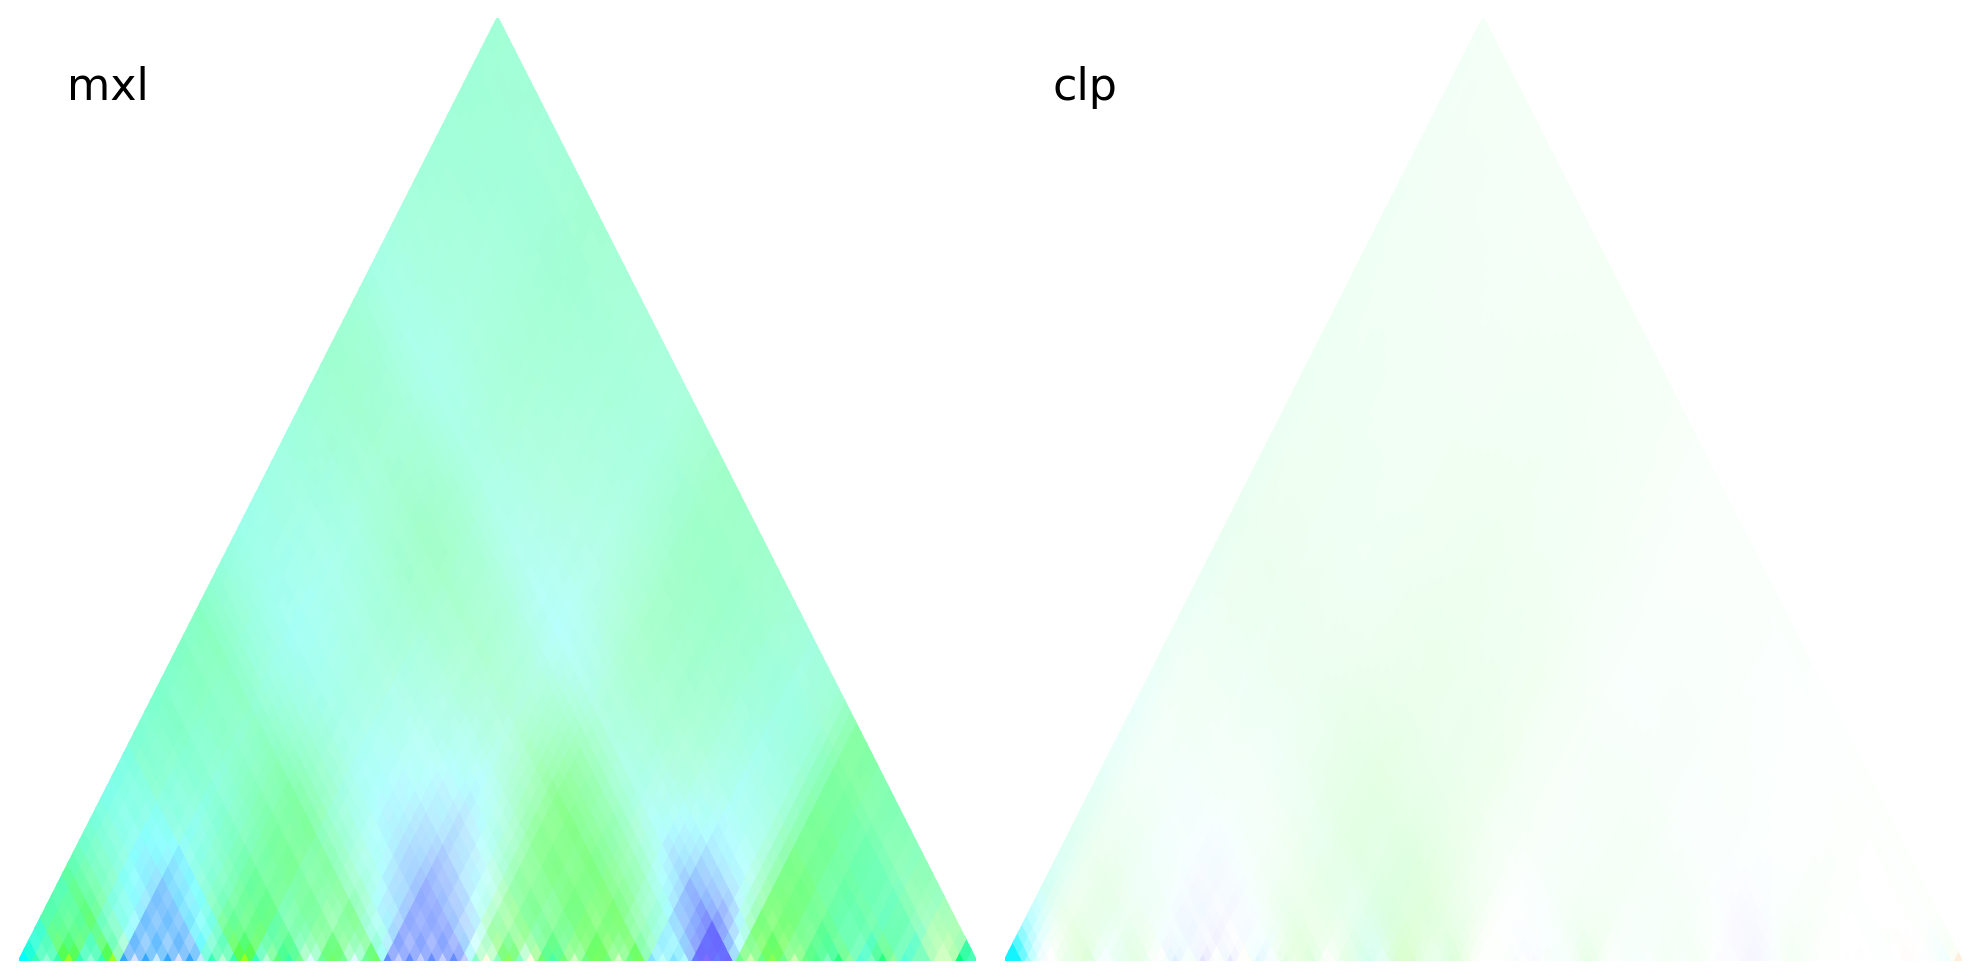

In [9]:
mk_xml_aw = 4 #87 bars * 4 == 348 quarter notes in length
mk_mp3_aw = 1.5 #2:34 == 154s
symbolic_vs_audio(mk_xml, mk_audio, mk_xml_aw, mk_mp3_aw, 500, 5)

/Users/cedricviaccoz/wavescapes/tutorials/wavescapes/color.py:200: UserWarning: Max magnitude of 0.940060 observed for coeff. number 5, boosting all magnitudes by 106.38% of their original values
  warn(msg)


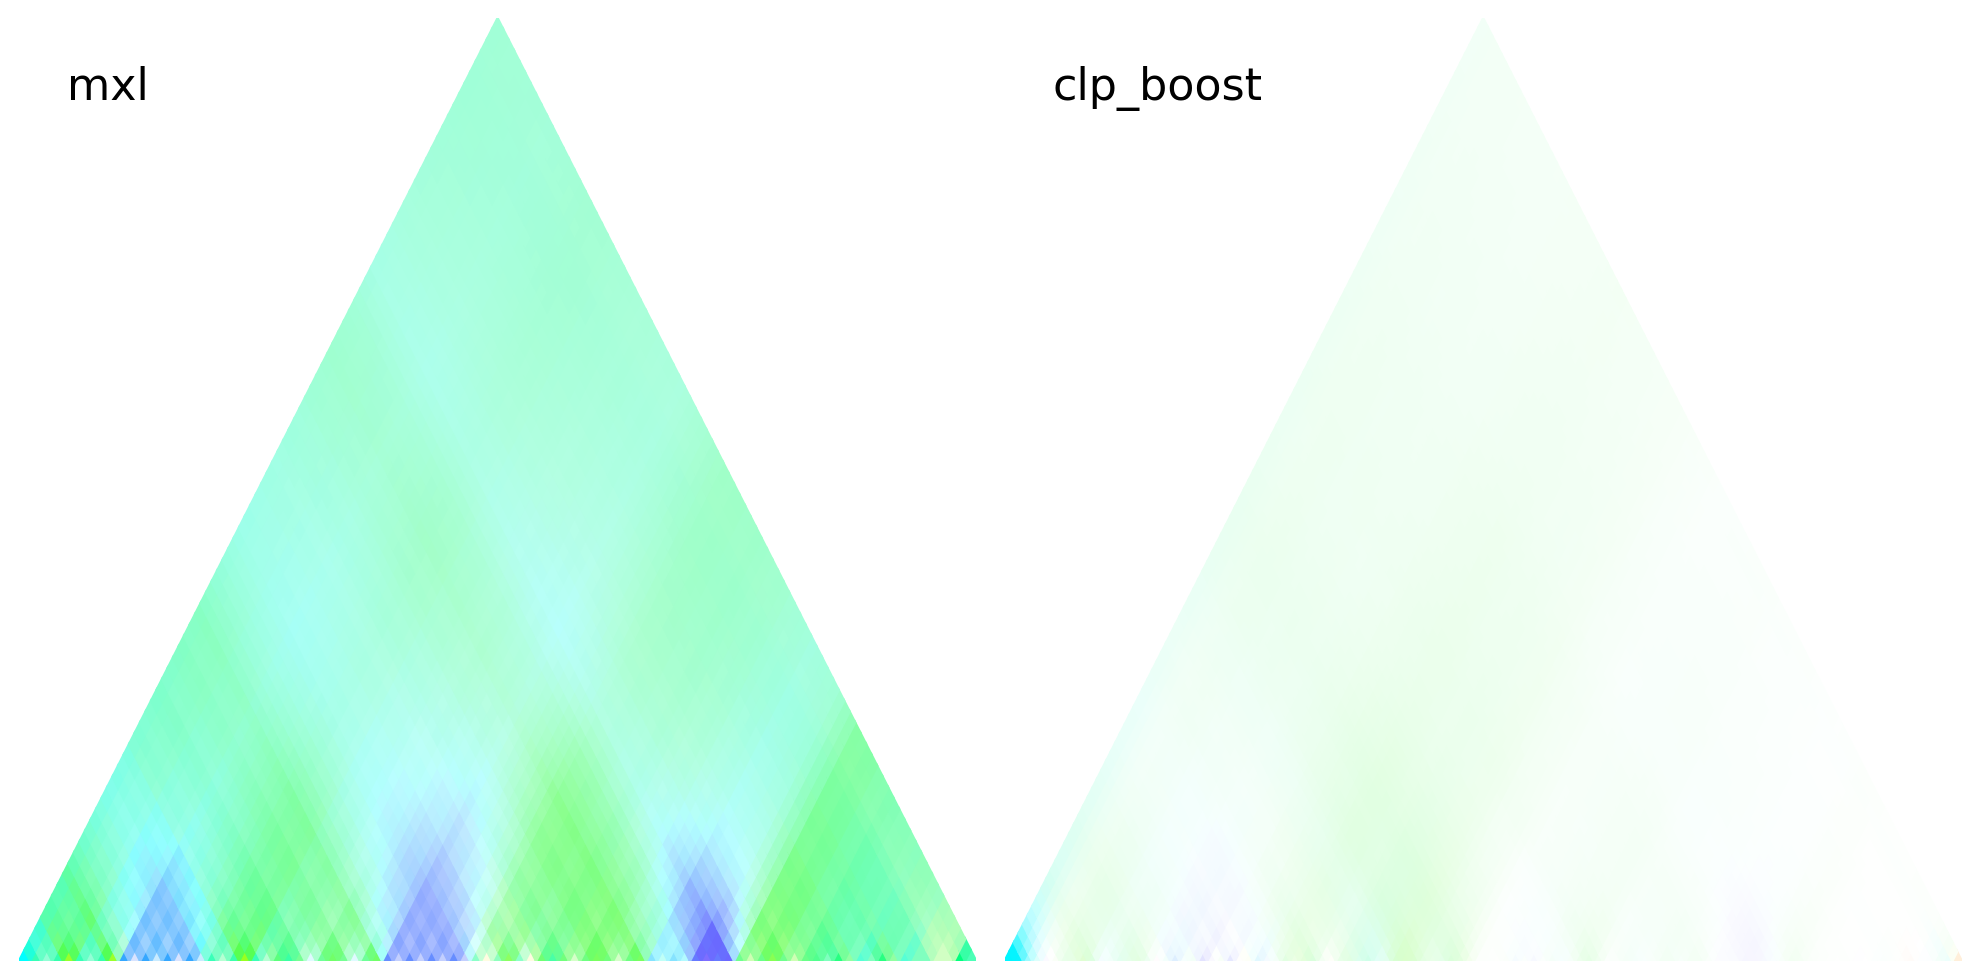

In [10]:

symbolic_vs_audio(mk_xml, mk_audio, mk_xml_aw, mk_mp3_aw, 500, 5, boosting=True)

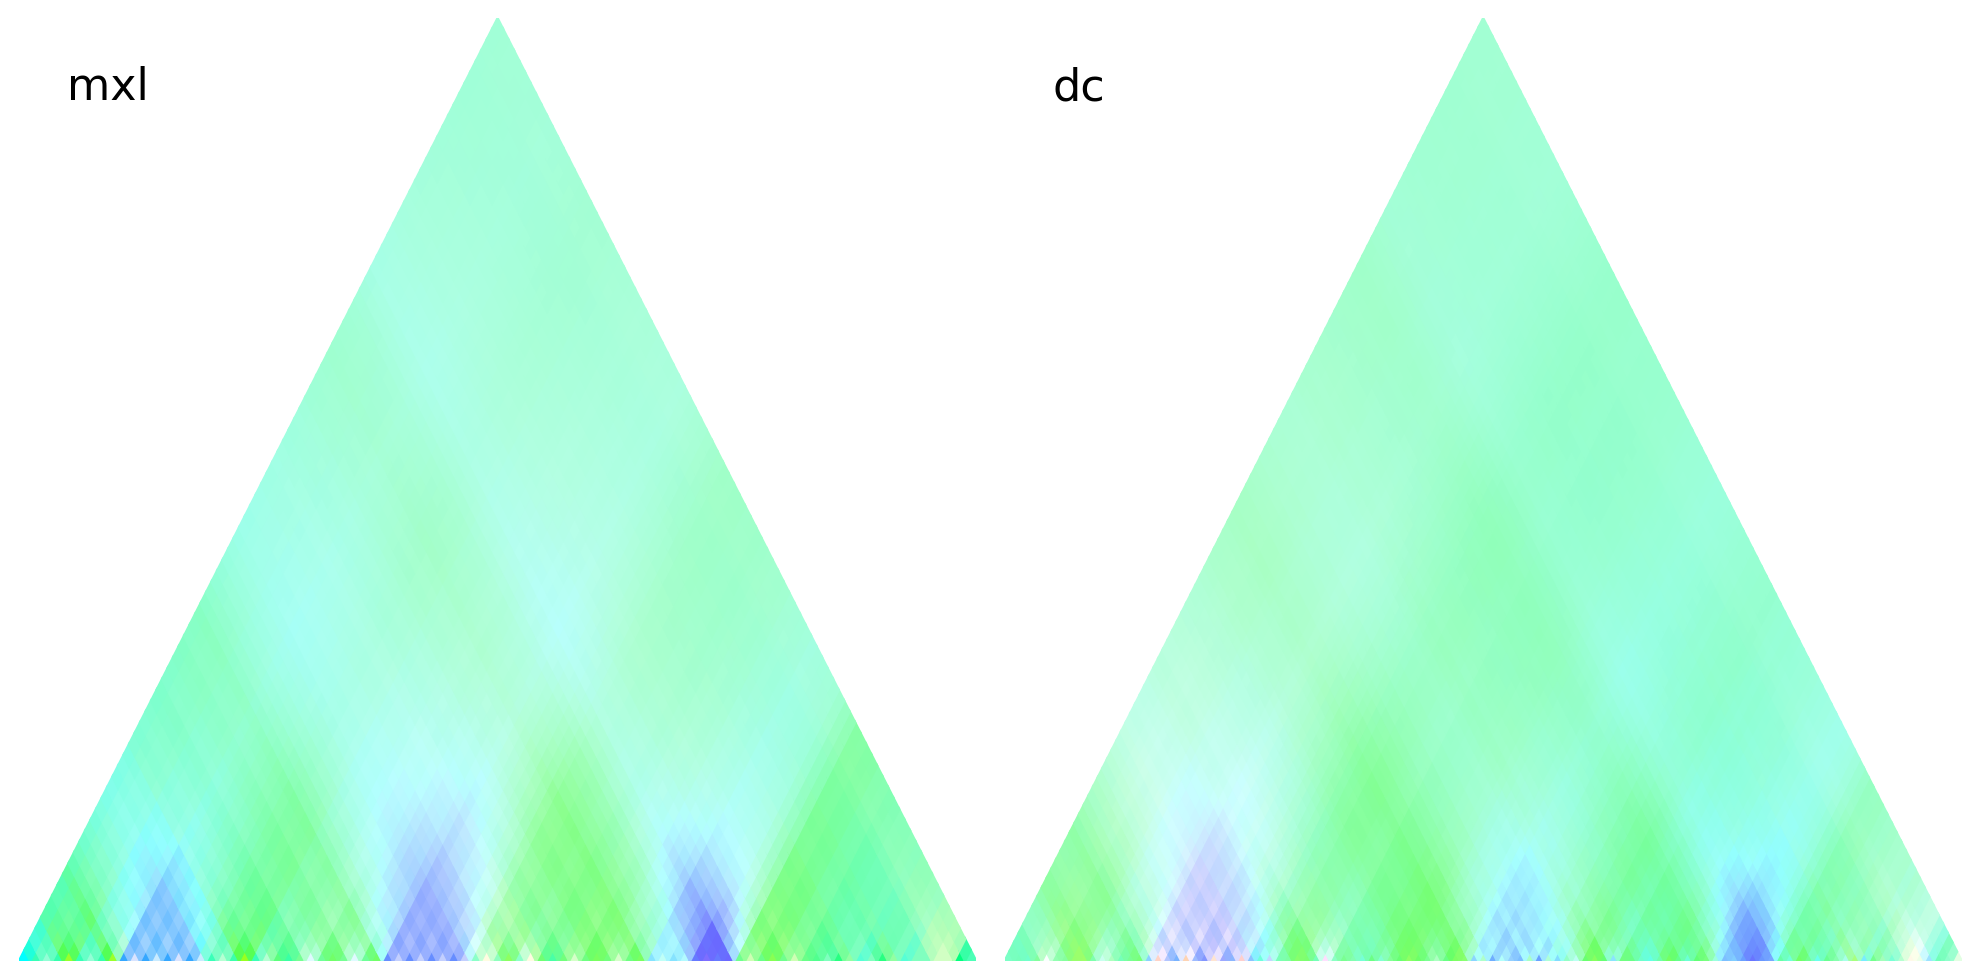

In [11]:

symbolic_vs_audio(mk_xml, mk_audio, mk_xml_aw, mk_mp3_aw, 500, 5, deep_chroma=True)